In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
from os.path import join
from scipy.spatial.distance import cdist    
from scipy.sparse import csgraph

# Run1

In [ ]:
data_path = '/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/selected_voxels_session1_run1.nii.gz'
stat_img = nib.load(data_path)
selected_voxels = stat_img.get_fdata() #binary matrix (90,120,85)

results = np.load('/Users/zkavian/Downloads/GLMOutputs2-sub04-ses01/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
beta_values = betasmd = results['betasmd'][:,:,:,0:90]  #(90,120,85,90)

v1 = beta_values[selected_voxels.astype(bool), :] #(8252, 90)
mean_v1 = np.mean(v1, axis=-1)
C1 = 1./np.abs(mean_v1)

# print(f"Max: {C1.max()}")
# print(f"mean: {C1.mean()}")
# print(f"Min: {C1.min()}")

Max: 151.166259765625
mean: 4.421987533569336
Min: 0.03127579763531685


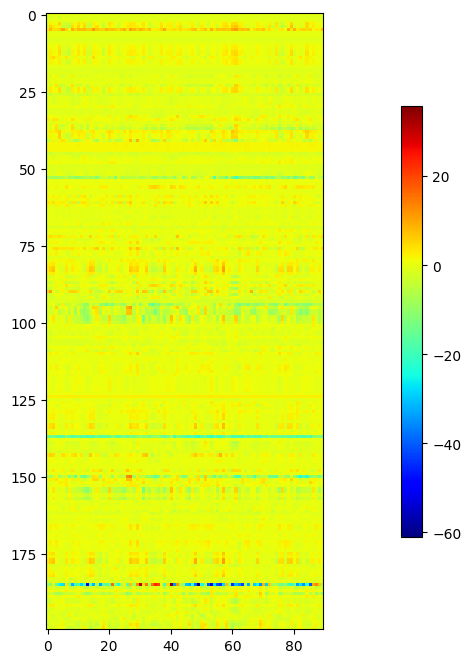

In [ ]:
# plt.figure(figsize=(20,8))
# img = plt.imshow(v1[:200], cmap='jet')
# plt.colorbar(img, shrink=0.7)
# plt.show()

In [8]:
base_path = '/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
sub = '04'
ses = '2'
run = '1'

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
data_path_org = join(base_path, f'sub-pd0{sub}',f'ses-{ses}','func', data_name)
data_run1 = nib.load(data_path_org).get_fdata() #(90, 128, 85, 850)

In [ ]:
select_data = data_run1[selected_voxels.astype(bool), :]
# print(select_data.shape)

num_trials = 90
trial_len = 9
active_voxel_data = np.zeros((select_data.shape[0], num_trials, trial_len))

start = 0
for i in range(num_trials):
    active_voxel_data[:, i, :] = select_data[:, start:start+trial_len]
    start += trial_len
    if start == 270 or start == 560:
        start += 20

# print(active_voxel_data.shape)

(8252, 850)
(8252, 90, 9)


In [ ]:
diff_mat = np.diff(active_voxel_data, axis=1)
diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
C2 = diff_mat_flat @ diff_mat_flat.T
C2 = C2 / active_voxel_data.shape[1]
# C2.shape

(8252, 8252)

In [11]:
anat_img = nib.load('/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz')
anat_data = anat_img.get_fdata()

In [ ]:
affine = anat_img.affine
shape = anat_img.shape

# Get all voxel indices
coords = np.array(np.meshgrid(
    np.arange(shape[0]),
    np.arange(shape[1]),
    np.arange(shape[2]),
    indexing='ij'
)).reshape(3, -1).T

# Convert to world (scanner/MNI) coordinates
world_coords = nib.affines.apply_affine(affine, coords)
tmp = selected_voxels.astype(bool).reshape(-1)
selected_world_coords = world_coords[tmp,:]

D = cdist(selected_world_coords, selected_world_coords)  

# np.fill_diagonal(D, np.inf)
# Q = 1./D
# q = np.mean(Q, axis=0)
# L4 = np.diag(q) - Q

L4 = csgraph.laplacian(D)

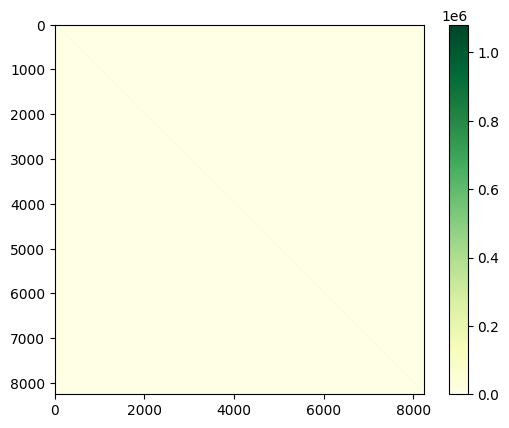

In [ ]:
# plt.figure()
# plt.imshow(L4, cmap='YlGn')
# plt.colorbar()
# plt.show()